# An analysis of the State of the Union speeches - Part 2

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import shelve
import nltk 

plt.style.use('seaborn-dark')
plt.rcParams['figure.figsize'] = (10, 6)
sns.set_style('whitegrid')

Let's start by loading some of the data created in the previous part, so we can continue where we left off:

In [17]:
addresses_df = pd.read_hdf('results/addresses_df_1.h5', 'addresses_df')

Let's double-check that we're getting the full set of speeches:

In [18]:
print(addresses_df.shape)

(227, 4)


## Basic text analysis

Let's ask a few basic questions about this text, by populating our `addresses` dataframe with some extra information. As a reminder, so far we have:

In [19]:
addresses_df.head()

,Date,Date (String),President,Speech
0,1790-01-08,January 8 1790,George Washington,State of the Union Address
1,1790-12-08,December 8 1790,George Washington,State of the Union Address
2,1791-10-25,October 25 1791,George Washington,State of the Union Address
3,1792-11-06,November 6 1792,George Washington,State of the Union Address
4,1793-12-03,December 3 1793,George Washington,State of the Union Address


Now, let's add the following information to this DF:

* `n_words`: number of words in the speech
* `n_uwords`: number of *unique* words in the speech
* `n_swords`: number of *unique, stemmed* words in the speech
* `n_chars`: number of letters in the speech
* `n_sent`: number of sentences in the speech

For this level of complexity, it's probably best if we go with NLTK. Remember, that `speeches` is our list with all the speeches, indexed in the same way as the `addresses` dataframe:

In [20]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from string import punctuation 

def clean_word_tokenize(doc):
    """custom word tokenizer which removes stop words and punctuation. 
    
    Parameters
    ----------
    doc : string
        A document to be tokenized
        
    Returns
    -------
    tokens
    """
    
    doc = doc.lower() #turn all words to lowercase for standardization 
    
    #From lecture 11
    #https://berkeley-stat159-f17.github.io/stat159-f17/lectures/11-strings/11-nltk.html
    augmented_punctuation = list(punctuation) + ['--']
    empty_content = stopwords.words('english') + augmented_punctuation
    
    #tokenize words
    all_tokens = nltk.tokenize.word_tokenize(doc)
    
    #return each token if it is not punctuation or a stop word 
    return [token for token in all_tokens if token not in empty_content]

Now we compute these quantities for each speech, as well as saving the set of unique, stemmed words for each speech, which we'll need later to construct the complete term-document matrix across all speeches.

In [21]:
'''Returns number of words in a tokenized list'''
def n_words(token_list): 
    return len(token_list)

'''Returns number of unique words in a tokenized list'''
def n_uwords(token_list): 
    return len(set(token_list))

'''Returns total number of characters in a list of tokens.
Simply takes the number of characters in each token, and adds up 
all the values.'''
def n_chars(token_list): 
    return sum([len(token) for token in token_list])

'''Returns number of sentences in a speech string.'''
def n_sent(doc): 
    return len(nltk.tokenize.sent_tokenize(doc))

'''Returns the set of unique, stemmed words in a tokenized list.'''
def get_uq_stemmed_words(clean_tokens): 
    stemmer = PorterStemmer()
    stem_words_list = [stemmer.stem(token) for token in clean_tokens]
    return set(stem_words_list)

'''Returns the length set of unique, stemmed words.'''
def n_swords(stem_words_set): 
    return len(stem_words_set)

'''Returns the number of all words, including stop words.'''
def n_words_all(doc): 
    non_punctuation_words = [word for word in doc.split() if word not in list(punctuation)]
    return n_words(non_punctuation_words)

'''Returns the fraction of words which are stop words. 
To save computational time, it takes in a list of cleaned tokens 
without stop words, and a string of the speech.'''
def frac_stop_words(doc, clean_tokens): 
    all_words = doc.split()
    return (1 - len(clean_tokens)/len(all_words))

In [22]:
'''Reads a string which is an unprocessed speech. 

First, this returns a dictionary with the following:
n_sent: Number of sentences
n_words: Number of total words (after tokenizing and removing stop words)
n_uwords: Number of unique words
n_swords: Number of unique, stemmed words
n_chars: Number of chars 
n_words_all: Number of all words, including stop words

Second, this returns uq_stemmed_words, which is a set of all unique stemmed words.'''
def get_additional_speech_data(doc): 
    speech_data = {}
    clean_tokens = clean_word_tokenize(doc)
    all_words = doc.split(punctuation)
    uq_stemmed_words = get_uq_stemmed_words(clean_tokens)
    
    speech_data['n_sent'] = n_sent(doc)
    speech_data['n_words'] = n_words(clean_tokens)
    speech_data['n_uwords'] = n_uwords(clean_tokens)
    speech_data['n_swords'] = n_swords(uq_stemmed_words)
    speech_data['n_chars'] = n_chars(clean_tokens)
    speech_data['n_words_all'] = n_words_all(doc)
    speech_data['frac_stop_words'] = frac_stop_words(doc, clean_tokens)
    return speech_data, uq_stemmed_words

In [23]:
'''Create empty columns with zeros on them in anticipation of new values.'''

addresses_df['n_sent'] = pd.Series(np.zeros(len(addresses_df)), index=addresses_df.index)
addresses_df['n_words_all'] = pd.Series(np.zeros(len(addresses_df)), index=addresses_df.index)
addresses_df['n_words'] = pd.Series(np.zeros(len(addresses_df)), index=addresses_df.index)
addresses_df['n_uwords'] = pd.Series(np.zeros(len(addresses_df)), index=addresses_df.index)
addresses_df['n_swords'] = pd.Series(np.zeros(len(addresses_df)), index=addresses_df.index)
addresses_df['n_chars'] = pd.Series(np.zeros(len(addresses_df)), index=addresses_df.index)
addresses_df['frac_stop_words'] = pd.Series(np.zeros(len(addresses_df)), index=addresses_df.index)

In [24]:
#WARNING: This cell takes a few minutes to run. 

all_uq_words = set()

'''We make a first pass through the speeches text file to update the metadata in address_df 
and also to create a set of all unique words. 
Once this set of all unique words has been made, we can create a text matrix for each speech.'''
with open('data/stateoftheunion1790-2017.txt', 'r') as speeches_txt:
    txt_file_chunks = speeches_txt.read().split('***') 
    
    for index, row in addresses_df.iterrows():
        raw_speech = txt_file_chunks[index + 1].lower()
        speech_dict, speech_words_set = get_additional_speech_data(raw_speech)        
        all_uq_words.update(speech_words_set)
        for key in speech_dict.keys(): 
            addresses_df.set_value(index, key, speech_dict[key])

In [25]:
addresses_df.head()

,Date,Date (String),President,Speech,n_sent,n_words_all,n_words,n_uwords,n_swords,n_chars,frac_stop_words
0,1790-01-08,January 8 1790,George Washington,State of the Union Address,24.0,1093.0,509.0,386.0,347.0,3882.0,0.534309
1,1790-12-08,December 8 1790,George Washington,State of the Union Address,40.0,1413.0,639.0,498.0,448.0,4667.0,0.547771
2,1791-10-25,October 25 1791,George Washington,State of the Union Address,60.0,2313.0,1082.0,714.0,609.0,8091.0,0.532209
3,1792-11-06,November 6 1792,George Washington,State of the Union Address,61.0,2108.0,978.0,665.0,563.0,7134.0,0.536053
4,1793-12-03,December 3 1793,George Washington,State of the Union Address,56.0,1975.0,913.0,687.0,625.0,6511.0,0.537722


Let's look at a summary of these 

In [26]:
pd.options.display.precision = 2
addresses_df.describe()

,n_sent,n_words_all,n_words,n_uwords,n_swords,n_chars,frac_stop_words
count,227.00,227.00,227.00,227.00,227.00,227.00,227.00
mean,262.02,7566.78,3783.72,1603.67,1255.01,26154.37,0.50
std,173.37,5406.87,2742.03,740.71,501.36,19498.74,0.03
min,24.00,851.00,509.00,386.00,347.00,3458.00,0.41
25%,162.50,3950.00,2002.50,1054.50,880.50,13121.50,0.48
50%,237.00,6044.00,3109.00,1493.00,1208.00,21384.00,0.51
75%,340.50,9169.50,4503.50,1957.00,1508.00,31746.00,0.52
max,1305.00,33570.00,19663.00,4240.00,2975.00,140458.00,0.55


## Additional Characteristics 

For simplicity, we add three additional columns to the addresses_df dataframe, which we will visualize later. 

1. *Average Word Length*: This is simply $\frac{n_{chars}}{n_{words}}$

2. *Average Sentence Length*: This is simply $\frac{n_{words}}{n_{sent}}$

3. *Vocabulary size per word*: This is simply $\frac{n_{uwords}}{n_{words}}$. 

In [27]:
#initialize empty columns in the dataframe
addresses_df['avg_word_len'] = pd.Series(np.zeros(len(addresses_df)), index=addresses_df.index)
addresses_df['avg_sent_len'] = pd.Series(np.zeros(len(addresses_df)), index=addresses_df.index)
addresses_df['vocab_size_per_word'] = pd.Series(np.zeros(len(addresses_df)), index=addresses_df.index)

#compute the appropriate values
addresses_df['avg_word_len'] = addresses_df['n_chars']/addresses_df['n_words']
addresses_df['avg_sent_len'] = addresses_df['n_words']/addresses_df['n_sent']
addresses_df['vocab_size_per_word'] = addresses_df['n_uwords']/addresses_df['n_words']

addresses_df.head()

,Date,Date (String),President,Speech,n_sent,n_words_all,n_words,n_uwords,n_swords,n_chars,frac_stop_words,avg_word_len,avg_sent_len,vocab_size_per_word
0,1790-01-08,January 8 1790,George Washington,State of the Union Address,24.0,1093.0,509.0,386.0,347.0,3882.0,0.53,7.63,21.21,0.76
1,1790-12-08,December 8 1790,George Washington,State of the Union Address,40.0,1413.0,639.0,498.0,448.0,4667.0,0.55,7.30,15.97,0.78
2,1791-10-25,October 25 1791,George Washington,State of the Union Address,60.0,2313.0,1082.0,714.0,609.0,8091.0,0.53,7.48,18.03,0.66
3,1792-11-06,November 6 1792,George Washington,State of the Union Address,61.0,2108.0,978.0,665.0,563.0,7134.0,0.54,7.29,16.03,0.68
4,1793-12-03,December 3 1793,George Washington,State of the Union Address,56.0,1975.0,913.0,687.0,625.0,6511.0,0.54,7.13,16.30,0.75


## Visualizing characteristics of the speeches

Now we explore some of the relationships between the speeches, their authors, and time.

How properties of the speeches change over time.

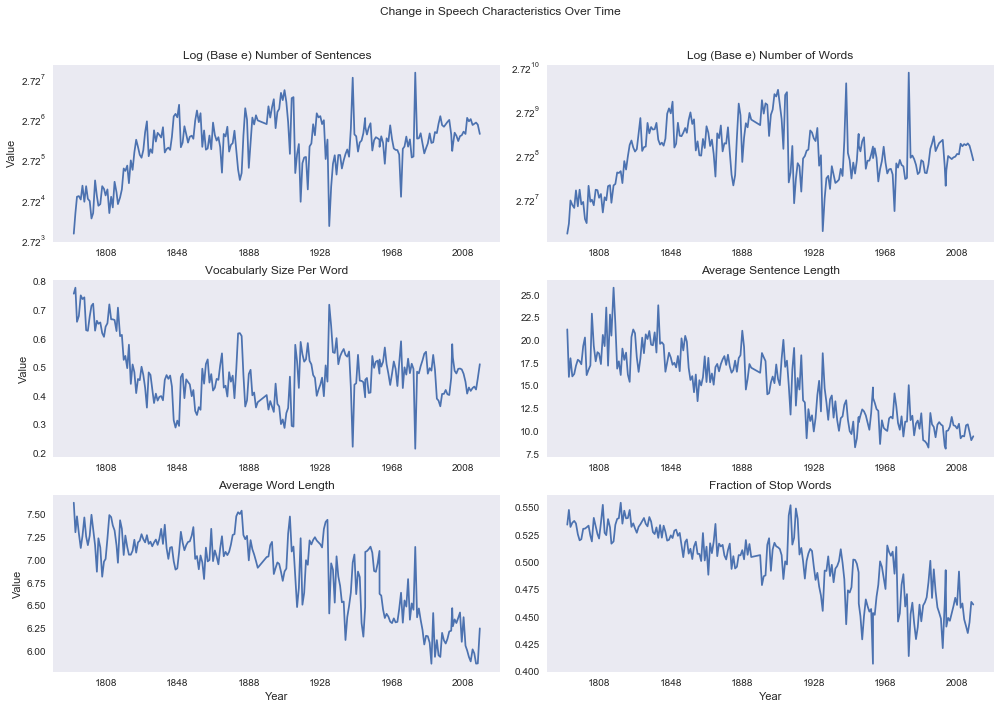

In [28]:
sns.set_style("dark")

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(14, 10))
ax = axs[0, 0]
ax.plot(addresses_df['Date'], addresses_df['n_sent'])
ax.semilogy(basey=np.round(np.e, decimals=2))
ax.set_title('Log (Base e) Number of Sentences')
ax.set_ylabel('Value')


ax = axs[0, 1]
ax.plot(addresses_df['Date'], addresses_df['n_words'])
ax.semilogy(basey=np.round(np.e, decimals=2))
ax.set_title('Log (Base e) Number of Words')

ax = axs[1, 0]
ax.plot(addresses_df['Date'], addresses_df['vocab_size_per_word'])
ax.set_title('Vocabularly Size Per Word')
ax.set_ylabel('Value')

ax = axs[1, 1]
ax.plot(addresses_df['Date'], addresses_df['avg_sent_len'])
ax.set_title('Average Sentence Length')

ax = axs[2, 0]
ax.plot(addresses_df['Date'], addresses_df['avg_word_len'])
ax.set_title('Average Word Length')
ax.set_ylabel('Value')
ax.set_xlabel('Year')

ax = axs[2, 1]
ax.plot(addresses_df['Date'], addresses_df['frac_stop_words'])
ax.set_title('Fraction of Stop Words')
ax.set_xlabel('Year')

plt.suptitle('Change in Speech Characteristics Over Time')
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.savefig('fig/speech_changes.png');

In [29]:
#make all strings title case
make_title_case = lambda string: string.title()
addresses_df['President'] = addresses_df['President'].apply(make_title_case)
addresses_df['Speech'] = addresses_df['Speech'].apply(make_title_case)

In [30]:
#for simplicity, we add 2 additional columns that are log scaled
addresses_df['log_n_words'] = np.log(addresses_df['n_words'])
addresses_df['log_n_sent'] = np.log(addresses_df['n_sent'])

Now for the distributions by president.

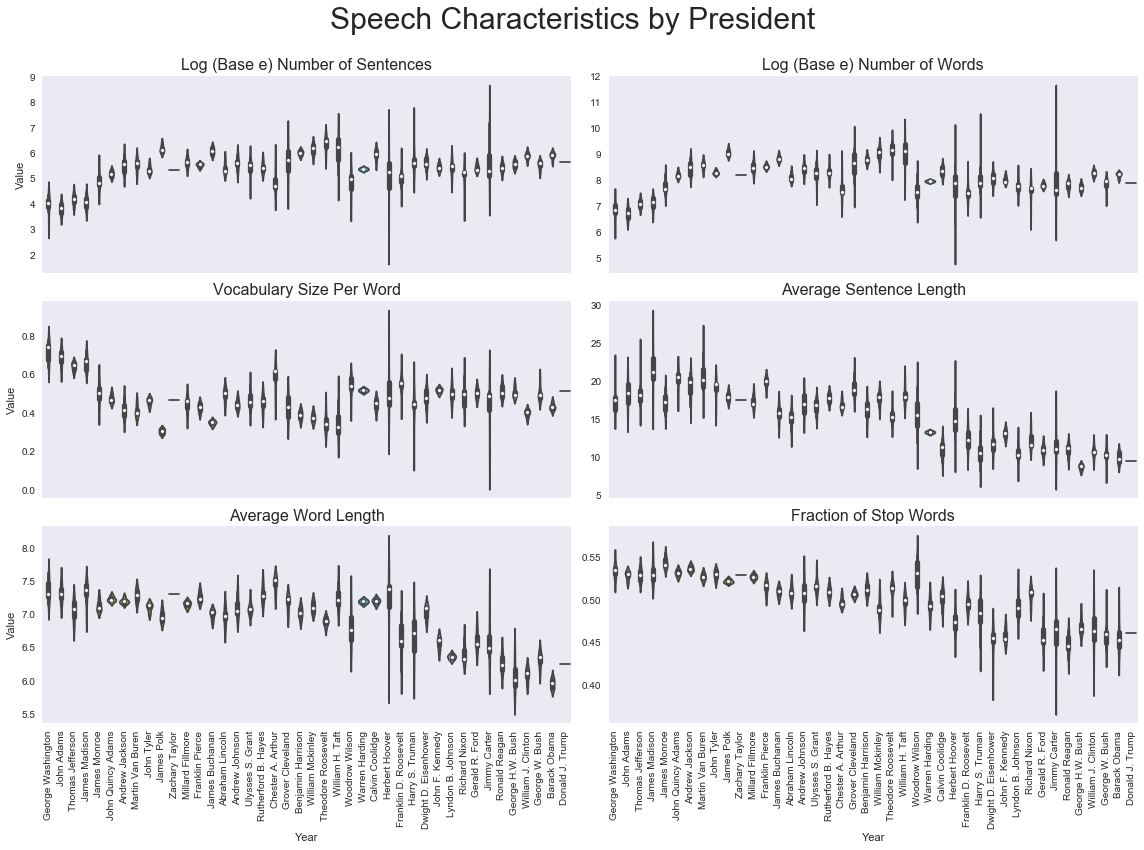

In [31]:
plotting_features = ['log_n_sent', 'log_n_words', 'vocab_size_per_word',  'avg_sent_len', 'avg_word_len', 'frac_stop_words']

melted_data = addresses_df.melt(id_vars=['President', 'Date (String)'], value_vars=plotting_features)

graph = sns.factorplot(x='President', y='value', col='variable', 
                       col_wrap=2, data=melted_data, kind="violin", size=4, aspect=2, sharey=False)
graph.set_axis_labels('Year', 'Value')

titles = ['Log (Base e) Number of Sentences', 'Log (Base e) Number of Words', 'Vocabulary Size Per Word', 
         'Average Sentence Length', 'Average Word Length', 'Fraction of Stop Words']

#adjust axis titles and rotate x ticks
for ax, title in zip(graph.axes.flat, titles):
    ax.set_title(title, fontsize=16)
    for label in ax.get_xticklabels():
        label.set_rotation(90)

plt.suptitle('Speech Characteristics by President', fontsize=30)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.savefig("fig/speech_characteristics.png");

## Intermediate results storage

Since this may have taken a while, we now serialize the results we have for further use. Note that we don't overwrite our original dataframe file, so we can load both (even though in this notebook we reused the name `addresses`):

In [32]:
addresses_df.to_hdf('results/addresses_df_2.h5', 'addresses_df')

with shelve.open('results/vars2') as db:
    db['all_uq_stemmed_words'] = all_uq_words